Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


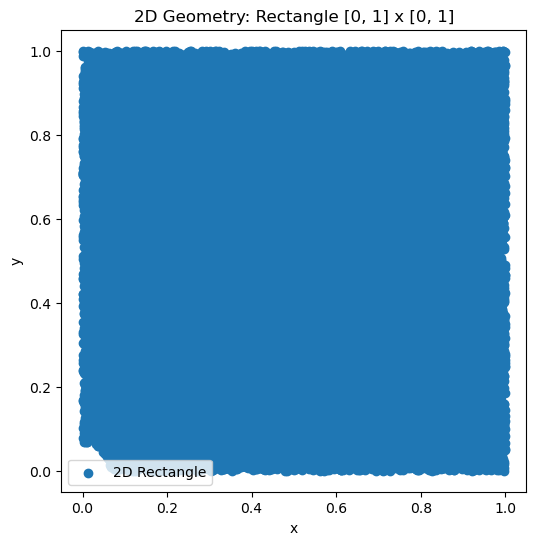

Compiling model...
'compile' took 0.030087 s

Training model...

Step      Train loss    Test loss     Test metric
0         [2.60e+03]    [2.62e+03]    []  
1000      [1.31e+03]    [1.34e+03]    []  
2000      [1.04e+03]    [1.07e+03]    []  
3000      [8.57e+02]    [8.96e+02]    []  
4000      [7.41e+02]    [7.83e+02]    []  
5000      [6.76e+02]    [7.21e+02]    []  
6000      [6.48e+02]    [6.95e+02]    []  
7000      [6.40e+02]    [6.89e+02]    []  
8000      [6.39e+02]    [6.88e+02]    []  
9000      [6.39e+02]    [6.88e+02]    []  
10000     [6.39e+02]    [6.88e+02]    []  
11000     [6.39e+02]    [6.88e+02]    []  
12000     [2.19e+02]    [2.18e+02]    []  
13000     [1.50e+02]    [1.47e+02]    []  
14000     [1.09e+02]    [1.07e+02]    []  
15000     [8.10e+01]    [7.84e+01]    []  
16000     [5.92e+01]    [5.70e+01]    []  
17000     [4.25e+01]    [4.08e+01]    []  
18000     [2.98e+01]    [2.87e+01]    []  
19000     [2.04e+01]    [1.97e+01]    []  
20000     [1.35e+01]    [

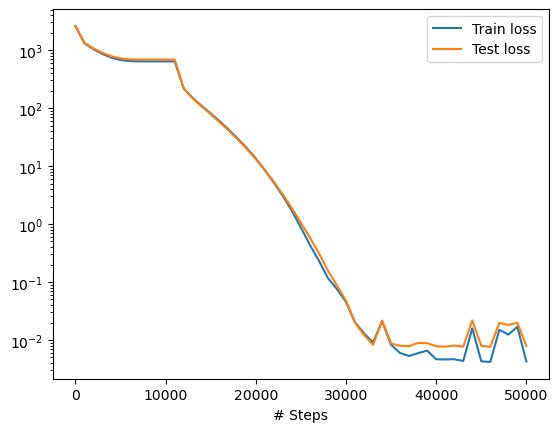

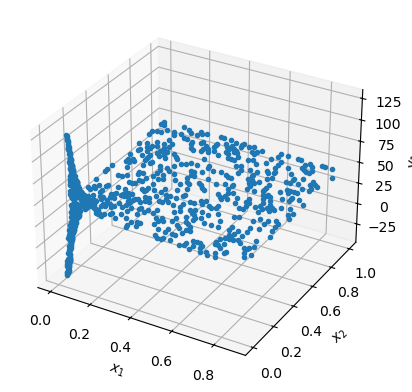

Compiling model...
'compile' took 0.001676 s

Training model...

Cause: could not parse the source code of <function <lambda> at 0x0000025239DCF1A0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x0000025239DCF1A0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @

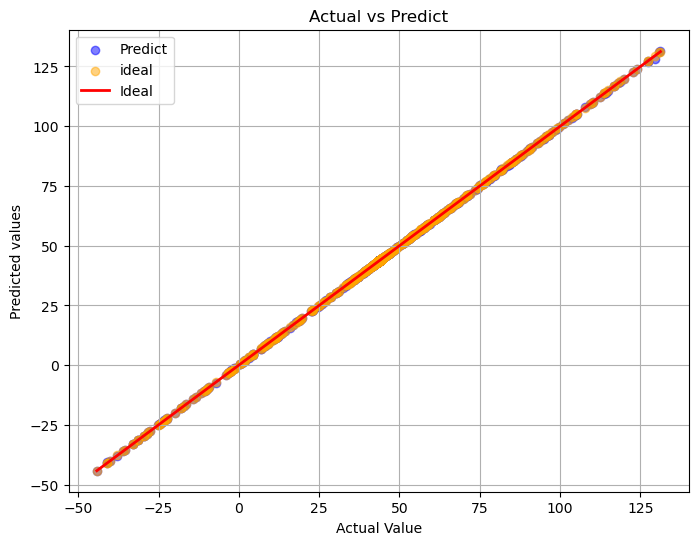

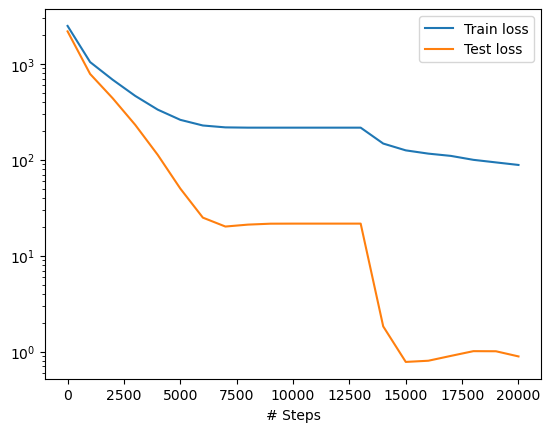

In [1]:
#PINN Case 2
#Please read Case 1 before proceeding the following.
#Backend Selection (must before import DeepXDE)
import os
os.environ['DDE_BACKEND'] = 'tensorflow' #To connect two networks, tensorflow is used instead of compat.v1
#Import libraries for DeepXDE
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow_probability as tfp
import deepxde as dde
import matplotlib.pyplot as plt

#Normalised Domain Variables
L =1            #m
R= 4e-3/6e-2    #m
t_last=1        #s
#Define the geometry size and its orgin
square = dde.geometry.Rectangle([0, 0], [L, L])
circle = dde.geometry.Disk([0, 0], R)

#Apply Constructive Solid Geometry Method to build a plate with centre hole by deleting a circular geometry on a plate
#Remeber that a quarter of plate is applied.
geom = dde.geometry.csg.CSGDifference(square, circle)
timedomain = dde.geometry.TimeDomain(0, t_last)
#Combine geometry and time
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

#A trick I use to sample points on the domain to view your domain definition is correct
Samp = geom.random_points(30000)
#Plot the domain based on the sampling points
plt.figure(figsize=(6, 6))
plt.scatter(Samp[:, 0], Samp[:, 1], marker='o', label="2D Rectangle")
plt.title("2D Geometry: Rectangle [0, 1] x [0, 1]")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

#Two models are created in Case 2. One to learn the hydrostatic stress based on supervised learning. Another uses PINN with simplified PDE.
#Both models apply the same DeepXDE library. (Supervised learning is achieved by replacing PDE to data set.)

###Hydrostatic Stress Model
#Read hydrostatic data
df = pd.read_excel('Hydrostatic Data with Nodes.xlsx')
#Set amount of data will be used
n = 2000 
sampled_data = df.sample(n=n)
#Split the data into training and testing sets
train_data, test_data = train_test_split(sampled_data, test_size=0.4, random_state=42)
#Extract coordinate data for training
x_train = np.array(train_data['x'].values).reshape(-1, 1)  # Extract the x values for training
y_train = np.array(train_data['y'].values).reshape(-1, 1)   # Extract the y values for training
#Extract stress data for training
sigma_train =np.array(train_data['sigma'].values).reshape(-1, 1)  # Extract the sigma values for training

#Same extractions for testing
x_test = np.array(test_data['x'].values).reshape(-1, 1)  # Extract the x values for testing
y_test = np.array(test_data['y'].values).reshape(-1, 1)  # Extract the y values for testing
sigma_test = np.array(test_data['sigma'].values).reshape(-1, 1) # Extract the sigma values for te

#Compile x and y data before Normalising all data
data_x=np.column_stack((x_train,y_train))/6e-2
data_sigma=np.array(sigma_train)/10**6
test_x=np.column_stack((x_test,y_test))/6e-2
test_sigma=np.array(sigma_test)/10**6

#Build data for supervised learning. The {DataSet} definition allows to do supervised learning from DeepXDE library
data = dde.data.dataset.DataSet(X_train=data_x, y_train=data_sigma, X_test=test_x, y_test=test_sigma)

#Network structure
layer_size = [2] + [64] * 8 + [1]  # 2 inputs (x, y ) -> hidden layers -> 1 output (σ)
activation = "tanh"
initializer = "Glorot uniform"
#Network Compile
net_sigma = dde.nn.FNN(layer_size, activation,initializer)
#Model Compile
model_sigma = dde.Model(data, net_sigma)
model_sigma.compile("adam", lr=1e-4)
losshistory, train_state = model_sigma.train(epochs=50000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

#Plot the prediction vs true on the supervised model
predict_s=model_sigma.predict(test_x)
plt.figure(figsize=(8,6))
plt.scatter(test_sigma,predict_s, color='blue',label='Predict', alpha=0.5)
plt.scatter(test_sigma,test_sigma, color='orange',label='ideal', alpha=0.5)
plt.plot([min(test_sigma),max(test_sigma)],[min(test_sigma),max(test_sigma)], color='red',label="Ideal",linewidth=2)
plt.title("Actual vs Predict")
plt.xlabel("Actual Value")
plt.ylabel("Predicted values")
plt.legend()
plt.grid(True)
plt.show




#This forbids the neurons in the trained network to be modified. This is important since we wish to use the trained stress netowrk to
#be a reference for training the concentration network.
net_sigma.trainable = False

####Concentration Model
#Define the initial condition of 20 mole per cubic meter everywhere.
ic = dde.icbc.IC(geomtime, lambda x: 20.0, lambda x, on_initial: on_initial, component=0)

#Define simplified PDE derived in the report section 5.3.1.
def pde_C_L(x, y):
    D_L = 3.8e-1    #m^2/s
    V_H = 2e-6      #m^3/mole
    RT= 8.314*298   #J/mole
    Coe=(D_L*V_H)/(RT)
    C_L=y[:,0:1]
    Sig=y[:,1:2]

    #Gradient definition
    #This is explained quite well in case 1
    dC_dt = dde.grad.jacobian(y, x, i=0, j=2)
    CL_x=dde.grad.jacobian( y, x, i=0, j=0)
    CL_y=dde.grad.jacobian( y, x, i=0, j=1)
    CL_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    CL_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    h_sigma_x = dde.grad.jacobian(Sig, x,i=0,j=0)
    h_sigma_y = dde.grad.jacobian(Sig, x,i=0,j=1)
    #Instead of applying hessian,user can also simply apply jaacobian twice to get second order PDE.
    #By using this technique, user can build any-order PDE
    h_sigma_xx = dde.grad.jacobian(h_sigma_x, x,i=0,j=0)
    h_sigma_yy = dde.grad.jacobian(h_sigma_y, x,i=0,j=1)

    #Extract spatial coordinates.
    cor = x[:, :2]
    #Get the sigma from the trained stress netowrk based on extracted coordinates.  
    sigma = net_sigma(cor)

    #There are two equations we wish DeepXDE to verify. One is the original simplified PDE. Another is to verify the
    #predicted stress with the trained stress. 
    #A special note is the addtion of 1e6. This 1e6 is used to de-normalise the hydrostatic stress.  
    eq1 = (dC_dt - D_L * (CL_xx + CL_yy)+ Coe * (CL_x* h_sigma_x*1e6 + CL_y * h_sigma_y*1e6 + C_L * (h_sigma_xx*1e6 + h_sigma_yy*1e6)))
    eq2=Sig-sigma
    return [eq1,eq2]

#Compile the data
data = dde.data.TimePDE(
    geomtime,
    pde_C_L, [ic],
    num_domain=800,
    num_boundary=500,
    num_initial=800,
    num_test=800,
    )
#Because the above definition, there will be 3 losses during training (2 for PDE, 1 for IC)
#Network structure for C_L
layer_size = [3] + [64] * 8 + [2]  
activation = "tanh"
initializer = "Glorot uniform"
#Network Compile
net_C_L = dde.nn.FNN(layer_size, activation, initializer)
#Model Compile
model= dde.Model(data, net_C_L)
model.compile("adam", lr=1e-4)
losshistory, train_state = model.train(iterations=20000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

MovieWriter imagemagick unavailable; using Pillow instead.


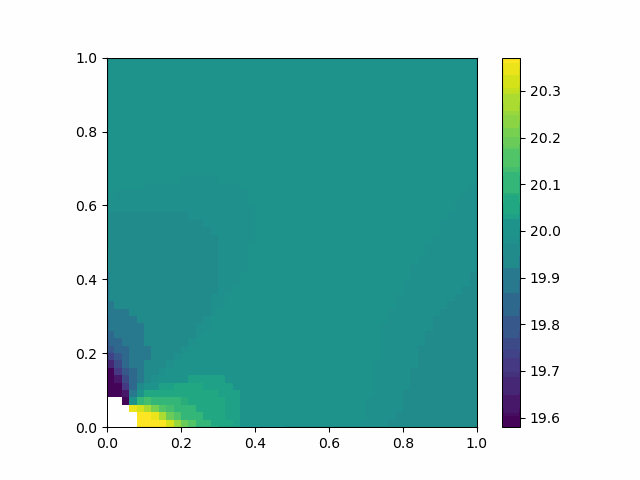

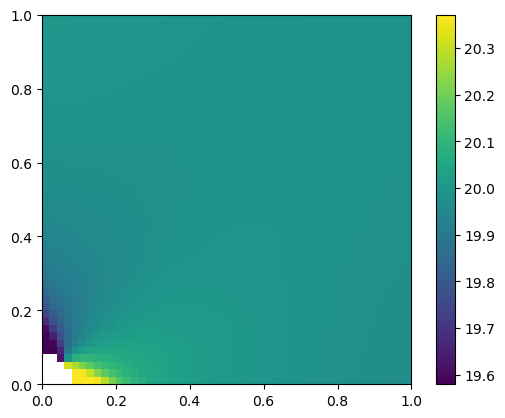

In [4]:
#Plot
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Image
from IPython.display import display

length=1 
resolution =50 #Increase it for better picture. I set it low to test
radius = 4e-3/6e-2
time=1
t = np.linspace(0, time, resolution)
x = np.linspace(0, length, resolution)
y = np.linspace(0, length, resolution)
data = np.zeros((resolution,resolution, resolution))
# Generate frames for each time step
for h in range(resolution):
    for i in range(resolution):
        for j in range(resolution):
            # Pass individual x, y, t values to model.predict()
            # Model output its prediction by model.predict() 
             prediction= model.predict([[x[i], y[j], t[h]]])[0][0]
             data[i, j , h]=prediction

             #Make sure no values at hole region
             if (x[i]**2 + y[j]**2) < radius**2:
                 data[i,j,h]=None
    
# Initialize the plot
fig, ax = plt.subplots()
data = np.transpose(data, (1, 0, 2))
contour = ax.imshow(data[:,:,0], extent=[0, length, 0, length], origin="lower", cmap="viridis")
fig.colorbar(contour)

# Update function for each frame
def update(frame):
    contour.set_data(data[:,:,frame])
    return [contour]

# Create the animation
anim = FuncAnimation(fig, update, frames=resolution, interval=500, blit=True)
anim.save("animation.gif", writer="imagemagick")
# Display the animation
display(Image(filename="animation.gif"))